# Hypothesis Testing

In [29]:
import pandas as pd
from scipy.stats import ttest_ind, levene, f_oneway, kruskal, shapiro, mannwhitneyu, wilcoxon, anderson
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import seaborn as sns

sns.set_theme(style="whitegrid")

In [5]:
df = pd.read_parquet('../../data/processed/train_enhanced.parquet')
df.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Order,Sales,Day_of_Week,Month,Year,Quarter,Week,Is_Weekend,log_Sales,log_Order,sqrt_Sales,sqrt_Order
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84,Monday,January,2018,1,1,0,8.855498,2.302585,83.736730,3.000000
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12,Monday,January,2018,1,1,0,10.854955,4.110874,227.572230,7.745967
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20,Monday,January,2018,1,1,0,10.515132,3.761200,192.010937,6.480741
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16,Monday,January,2018,1,1,0,9.889194,3.178054,140.410683,4.795832
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52,Monday,January,2018,1,1,0,10.728003,4.143135,213.575560,7.874008


# Impact of Discounts on Sales

Hypothesis: Stores offering discounts will have significantly higher sales than stores not offering discounts

- **Null Hypothesis:**  Stores offering discounts will have the same sales as stores not offering discounts
- **Alternative Hypothesis:** Stores offering discounts will have significantly higher sales than stores not offering discounts

## Using non transformed data
**Check if equal variance**

In [4]:
_, p_value =levene(df[df["Discount"]=='Yes']["Sales"], df[df["Discount"]=='No']["Sales"])
print(f"Levene test p-value: {p_value}")

Levene test p-value: 0.0


<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

Since p value 0, we reject the null hypothesis and conclude that the variances are not equal

In [5]:
_, p_value = ttest_ind(df[df["Discount"]=='Yes']["Sales"], df[df["Discount"]=='No']["Sales"], equal_var=False, alternative='less')
print(f"t-test p-value: {p_value}")

t-test p-value: 1.0


<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

Since p value is 0, it means we can reject the null hypothesis and accept the alternative hypothesis. This means that stores offering discounts will have significantly higher sales than stores not offering discounts.

## Using transformed data

In [39]:
_, p_value =levene(df[df["Discount"]=='Yes']["sqrt_Sales"], df[df["Discount"]=='No']["sqrt_Sales"])
print(f"Levene test p-value: {p_value}")

Levene test p-value: 1.63424045920766e-25


In [40]:
_, p_value = ttest_ind(df[df["Discount"]=='Yes']["sqrt_Sales"], df[df["Discount"]=='No']["sqrt_Sales"], equal_var=False, alternative='less')
print(f"t-test p-value: {p_value}")

t-test p-value: 1.0


# Effect of Holidays on Sales

Hypothesis: Sales on holidays are higher compared to non-holidays

- **Null Hypothesis:**  Sales on holidays are the same as sales on non-holidays
- **Alternative Hypothesis:** Sales on holidays are higher compared to non-holidays

## Using non transformed data
**Check if equal variance**

In [6]:
_, p_value = levene(df[df["Holiday"]==1]["Sales"], df[df["Holiday"]==0]["Sales"])
print(f"Levene test p-value: {p_value}")

Levene test p-value: 2.2515360393877834e-14


<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

Since p value is extremely small, we reject the null hypothesis and conclude that the variances are not equal

In [7]:
_, p_value = ttest_ind(df[df["Holiday"]==1]["Sales"], df[df["Holiday"]==0]["Sales"], equal_var=False, alternative='greater')
print(f"t-test p-value: {p_value}")

t-test p-value: 1.0


<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b> 

Since p value is 1, we fail to reject the null hypothesis. This means that sales on holidays are the same as sales on non-holidays.

## Using transformed data

In [43]:
_, p_value = levene(df[df["Holiday"]==1]["sqrt_Sales"], df[df["Holiday"]==0]["sqrt_Sales"])
print(f"Levene test p-value: {p_value}")

Levene test p-value: 0.0


In [44]:
_, p_value = ttest_ind(df[df["Holiday"]==1]["sqrt_Sales"], df[df["Holiday"]==0]["sqrt_Sales"], equal_var=False, alternative='greater')
print(f"t-test p-value: {p_value}")

t-test p-value: 1.0


# Sales Differences Across Store 

Hypothesis: Different store types experience different sales volumes

- **Null Hypothesis:**  Different store types experience the same sales volumes
- **Alternative Hypothesis:** Different store types experience different sales volumes

In [31]:
grouped = df.groupby(["Store_Type","Date"]).agg({"Sales":"sum"}).reset_index()
grouped.head()

,Store_Type,Date,Sales
0,S1,2018-01-01,7292027.67
1,S1,2018-01-02,8269809.00
2,S1,2018-01-03,7795536.00
3,S1,2018-01-04,8430363.00
4,S1,2018-01-05,9769758.00


In [32]:
s1_sales = grouped[grouped["Store_Type"]=="S1"]["Sales"]
s2_sales = grouped[grouped["Store_Type"]=="S2"]["Sales"]
s3_sales = grouped[grouped["Store_Type"]=="S3"]["Sales"]
s4_sales = grouped[grouped["Store_Type"]=="S4"]["Sales"]

In [37]:
s1_sales.shape, s2_sales.shape, s3_sales.shape, s4_sales.shape

((516,), (516,), (516,), (516,))

**Check if equal variance**

In [33]:
_, p_value = levene(s1_sales, s2_sales, s3_sales, s4_sales)
print(f"Levene test p-value: {p_value}")

Levene test p-value: 3.5045251295192814e-104


<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- Since p value is 0, we reject the null hypothesis and conclude that the variances are not equal

**Check if normal distribution**

In [34]:
stores = df["Store_Type"].unique()

for i in range(len(stores)):
    _, p_value = shapiro(grouped[grouped["Store_Type"]==stores[i]]["Sales"])
    print(f"Shapiro test p-value for store {stores[i]}: {p_value}")

Shapiro test p-value for store S1: 5.7405055751552957e-11
Shapiro test p-value for store S4: 2.925784346938242e-12
Shapiro test p-value for store S3: 7.258968300828844e-11
Shapiro test p-value for store S2: 1.1270988895293387e-10


In [35]:
f_oneway(s1_sales, s2_sales, s3_sales, s4_sales)

F_onewayResult(statistic=3372.920351561574, pvalue=0.0)

Since p value is 0, we can reject the null hypothesis and accept the alternative hypothesis. This means that different store types experience different sales volumes.

In [36]:
kruskal(s1_sales, s2_sales, s3_sales, s4_sales)

KruskalResult(statistic=1659.9852364714243, pvalue=0.0)

# Regional Sales Variability

In [ ]:
grouped = df.groupby(["Store_Type","Date", ]).agg({"Sales":"sum"}).reset_index()
grouped.head()

In [7]:
r1 = df[df["Region_Code"] == "R1"]["Sales"]
r2 = df[df["Region_Code"] == "R2"]["Sales"]
r3 = df[df["Region_Code"] == "R3"]["Sales"]
r4 = df[df["Region_Code"] == "R4"]["Sales"]

In [9]:
_, p_value = levene(r1, r2, r3, r4)
print(f"Levene test p-value: {p_value}")

Levene test p-value: 0.0


In [13]:
for region in df["Region_Code"].unique():
    _, p_value = shapiro(df[df["Region_Code"]==region]["Sales"])
    print(f"Shapiro test p-value for region {region}: {p_value}")
print();

Shapiro test p-value for region R1: 5.568579127456188e-90
Shapiro test p-value for region R4: 2.5918854183877692e-68
Shapiro test p-value for region R2: 6.326690054699451e-85
Shapiro test p-value for region R3: 1.174723480209048e-78



In [23]:
for region in df["Region_Code"].unique():
    _, p_value = shapiro(df[df["Region_Code"]==region]["sqrt_Sales"])
    print(f"Shapiro test p-value for region {region}: {p_value}")
print();

Shapiro test p-value for region R1: 1.397381562082319e-50
Shapiro test p-value for region R4: 1.4073956161795737e-42
Shapiro test p-value for region R2: 4.523253824461535e-54
Shapiro test p-value for region R3: 1.002411715276229e-51



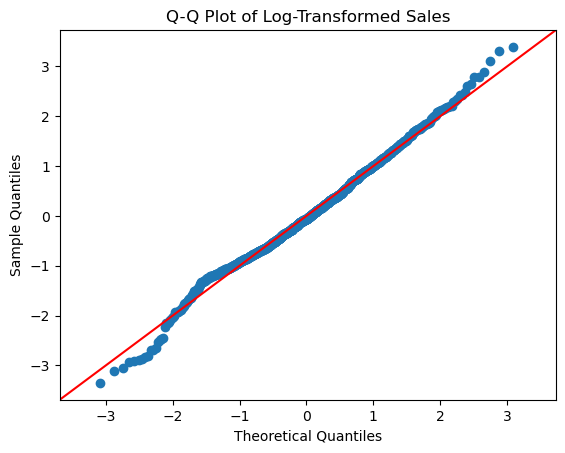

In [27]:
sm.qqplot(df[df["Region_Code"]=="R1"]["sqrt_Sales"].sample(1000), line ='45', fit=True)
plt.title('Q-Q Plot of Log-Transformed Sales');

# Correlation between Number of Orders and Sales

In [28]:
df

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Order,Sales,Day_of_Week,Month,Year,Quarter,Week,Is_Weekend,log_Sales,log_Order,sqrt_Sales,sqrt_Order
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84,Monday,January,2018,1,1,0,8.855498,2.302585,83.736730,3.000000
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12,Monday,January,2018,1,1,0,10.854955,4.110874,227.572230,7.745967
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20,Monday,January,2018,1,1,0,10.515132,3.761200,192.010937,6.480741
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16,Monday,January,2018,1,1,0,9.889194,3.178054,140.410683,4.795832
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52,Monday,January,2018,1,1,0,10.728003,4.143135,213.575560,7.874008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188335,T1188336,149,S2,L3,R2,2019-05-31,1,Yes,51,37272.00,Friday,May,2019,2,22,0,10.526024,3.951244,193.059576,7.141428
188336,T1188337,153,S4,L2,R1,2019-05-31,1,No,90,54572.64,Friday,May,2019,2,22,0,10.907306,4.510860,233.607877,9.486833
188337,T1188338,154,S1,L3,R2,2019-05-31,1,No,56,31624.56,Friday,May,2019,2,22,0,10.361721,4.043051,177.832955,7.483315
188338,T1188339,155,S3,L1,R2,2019-05-31,1,Yes,70,49162.41,Friday,May,2019,2,22,0,10.802905,4.262680,221.725980,8.366600


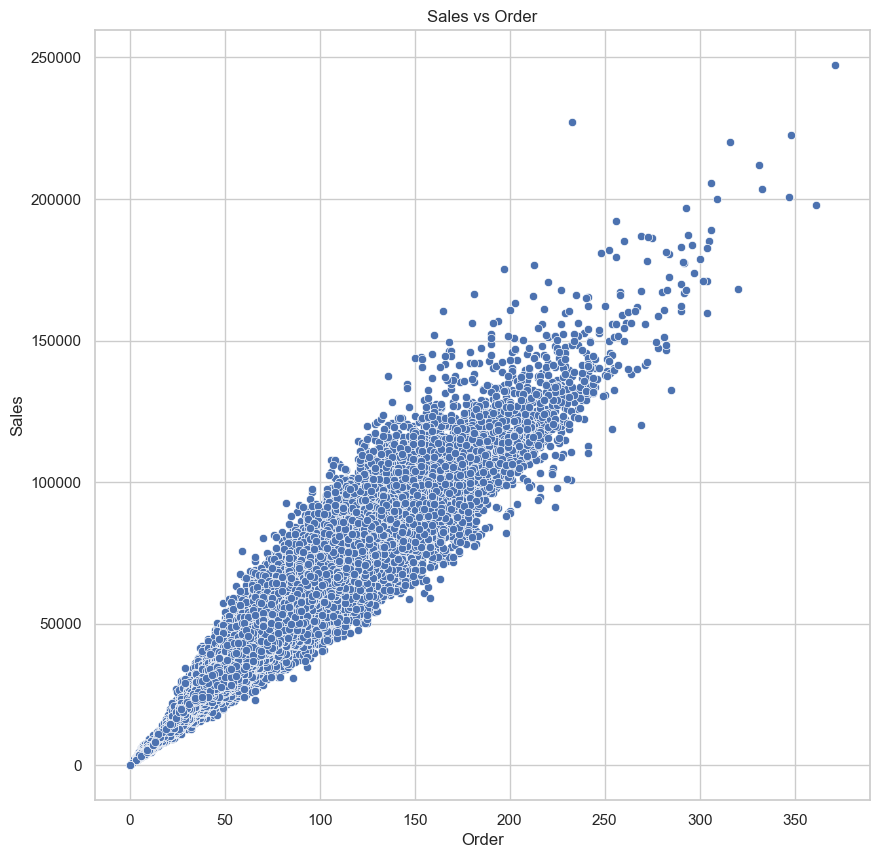

In [31]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df, x="Order", y="Sales");
plt.title("Sales vs Order");

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- From above plot we can see that there is a positive correlation between number of orders and sales. This means that as the number of orders increase, sales also increase.

<Axes: >

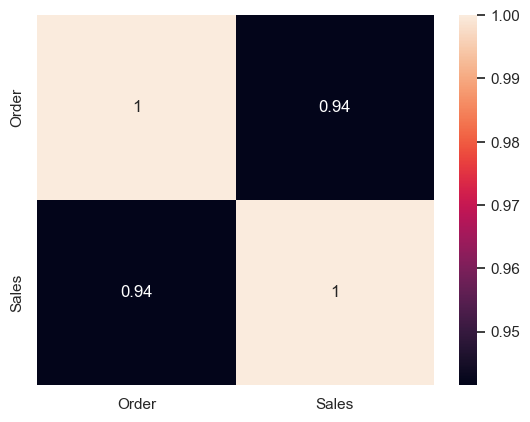

In [35]:
sns.heatmap(df[["Order", "Sales"]].corr(), annot=True)

<Axes: >

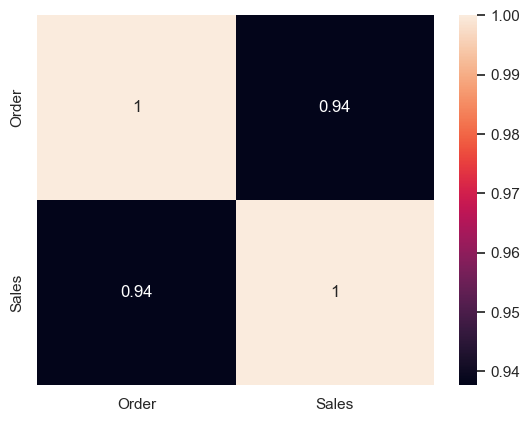

In [36]:
sns.heatmap(df[["Order", "Sales"]].corr(method="spearman"), annot=True)